## Latent visualization space
Script for visualizing latent space for the RNNVAE. Visualization of selected dimensions, over time, testing visualization, colors, the like.

WARNING: messy Script

In [14]:
# working dir
%cd /homedtic/gmarti/CODE/RNN-VAE/

# Imports
import sys
import os
sys.path.insert(0, '/homedtic/gmarti/CODE/RNN-VAE/')
import math
import torch
import torch.nn as nn
import numpy as np
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
from torch.autograd import Variable
from rnnvae.rnnvae import ModelRNNVAE
from sklearn.metrics import mean_absolute_error
from rnnvae.utils import open_MRI_data_var
from rnnvae.plot import plot_losses, plot_trajectory, plot_total_loss, plot_z_2d, plot_z_time_2d

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/homedtic/gmarti/CODE/RNN-VAE


In [15]:
# Parameters, and load existing model
#hyperparameters
x_size = 40
h_size = 10
z_dim = 5
hidden = 5
n_layers = 1
n_epochs = 6000
clip = 10
learning_rate = 1e-3
batch_size = 128
seed = 1714
#working dir:

# out_dir
out_dir = "experiments/MRI_nopadding_lin/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

model = ModelRNNVAE(x_size, h_size, hidden, n_layers, 
                     hidden, n_layers, hidden,
                     n_layers, z_dim, hidden, n_layers,
                     clip, n_epochs, batch_size)

model.load(out_dir+'model.pt')

In [16]:
# LOAD DATA
#TODO: here we should load, someway, the labels corresponding to the subjects
# add a flag to the function to return them or something
#I would like to get, at least, age and dx
csv_path = "data/tadpole_mrionly.csv"
X_train, X_test, Y_train, Y_test = open_MRI_data(csv_path, train_set=0.8, normalize=True, return_covariates=True)

nfeatures = X_train[0].shape[1]

# Apply padding to both X_train and X_val
X_train_tensor = [ torch.FloatTensor(t) for t in X_train ]
X_train_pad = nn.utils.rnn.pad_sequence(X_train_tensor, batch_first=False, padding_value=np.nan)
X_test_tensor = [ torch.FloatTensor(t) for t in X_test ]
X_test_pad = nn.utils.rnn.pad_sequence(X_test_tensor, batch_first=False, padding_value=np.nan)

# Those datasets are of size [Tmax, Batch_size, nfeatures]
mask_train = ~torch.isnan(X_train_pad)
mask_test = ~torch.isnan(X_test_pad)

#convert those NaN to zeros
X_train_pad[torch.isnan(X_train_pad)] = 0
X_test_pad[torch.isnan(X_test_pad)] = 0

max_timepoints = X_train_pad.shape[0]
# Those datasets are of size [Tmax, Batch_size, nfeatures]

print(nfeatures)

# Predict the reconstructions from X_val and X_train
X_test_fwd = model.predict(X_test_pad)
X_train_fwd = model.predict(X_train_pad)

#Reshape features so that nsubjects go first
X_train_fwd['x'] = X_train_fwd['x'].transpose(0,1)
print(X_train_fwd['xnext'][0].shape)
X_train_fwd['xnext'] = np.array(X_train_fwd['xnext']).swapaxes(0,1)
X_train_fwd['zx'] = np.array(X_train_fwd['zx']).swapaxes(0,1)

X_test_fwd['x'] = X_test_fwd['x'].transpose(0,1)
X_test_fwd['xnext'] = np.array(X_test_fwd['xnext']).swapaxes(0,1)
X_test_fwd['zx'] = np.array(X_test_fwd['zx']).swapaxes(0,1)

40
(728, 40)


In [17]:
print(Y_train["DX"][3])

['MCI' 'MCI']


Now start testing on the actual latent space. I want to program three main ways of latent space visualization:

1. Classic latent space visualization: selecting a specific time point and two specific latent dimensions, plot a 2D projection. Color by diagnosis? or by what?

2. Trajectory: for a specific latent dimension z_t, plot a 2d line over all timepoints. Plot all the subjects as lines, then try to visualize a general trajectory for that dimension? Maybe make the function flexible enough to 

3. Trajectory on 2D space: for two specific dimensions, plot a 2d space with all the timepoints z, and color the z by timepoints. See if there is a structure in the time over the selected dimensions of the latent space.

In [18]:
#First get the latent space
#Note that we have to apply the mask all the same!

z_train = X_train_fwd['zx']
z_test = X_test_fwd['zx']


#Hack: instead of nfeatures, we have a latent space, with a different dimensionality. But we want to capture it anyway, so 
#just select a number of dimensions equals to z_dim (should be all true!)
z_train = [Z[mask_train[:,i,:z_dim]].reshape((-1, z_dim)) for (i, Z) in enumerate(z_train)]
z_test = [Z[mask_test[:,i,:z_dim]].reshape((-1, z_dim)) for (i, Z) in enumerate(z_test)]

In [19]:
##1 Classic latent space visualization
dim0 = 0
dim1 = 2
z_t = 3
color = 'AGE'

#prepare the data
train_z_d0 = np.array([x[z_t, dim0] for x in z_train if x.shape[0] > z_t])
train_z_d1 = np.array([x[z_t, dim1] for x in z_train if x.shape[0] > z_t])

test_z_d0 = np.array([x[z_t, dim0] for x in z_test if x.shape[0] > z_t ])
test_z_d1 = np.array([x[z_t, dim1] for x in z_test if x.shape[0] > z_t])

z_d0 = np.append(train_z_d0 , test_z_d0)
z_d1 = np.append(train_z_d1, test_z_d1)

#Select colors
train_color = np.array([x[z_t] for x in Y_train[color] if x.shape[0] > z_t])
test_color = np.array([x[z_t] for x in Y_test[color] if x.shape[0] > z_t])

color = np.append(train_color, test_color)

#run figure
plot_z_2d(z_d0, z_d1, z_t, color, [dim0, dim1], out_dir)

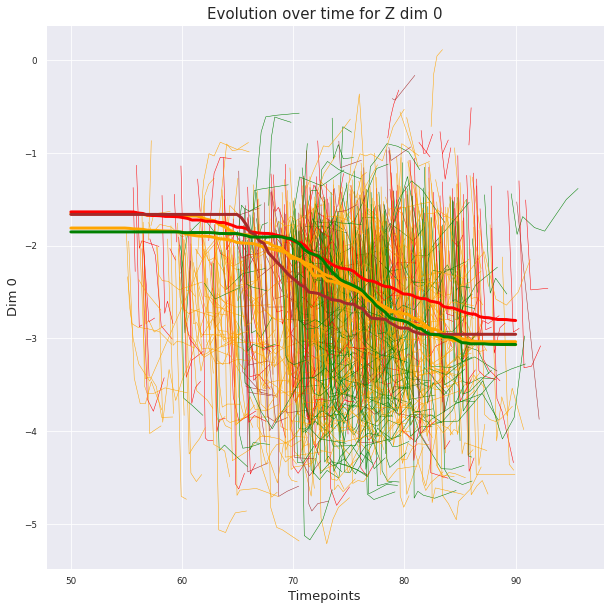

In [20]:
# 2 Trajectory latent space visualization
###THIS TRAJECTORY WILL NOT BE USED WIDELY SO LETS DONT PUT INTO A FUNCTION (ALSO IM LAZY)
dim = 4
color = 'DX_bl'
#TODO: THIS NEEDS TO BE SEPARATED BY SELECTED GROUPS
#COLOR SEMILINES BY DX AND THE MEAN LINES ALSO BY DX

#prepare the data
train_z_d0 = [x[:, dim0] for x in z_train]
test_z_d0 = [x[:, dim0] for x in z_test]
z_d0 = train_z_d0 + test_z_d0

#prepare DX labels
labels_train = [x[0] for x in Y_train[color]]
labels_test = [x[0] for x in Y_test[color]]
labels = labels_train + labels_test

# Prepare AGE for plotting
age_train = [x for x in Y_train["AGE"]]
age_test = [x for x in Y_test["AGE"]]
age = age_train + age_test

# TODO: WHY DO SOME AGE VALUES GO BACKWARDS IN TIME? AM I SURE THAT THERE HAS BEEN NO REORDERING?

dict_dx = {
    "AD": "red",
    "CN": "green",
    "SMC": "brown",
    "EMCI": "orange",
    "LMCI": "orange"
}

#plot all lines
#regarding the x axis: maybe it make sense to not use timepoints but...
#age?
# time from baseline?
#age probably is best
# TODO ADD AGE

plt.figure(figsize=(10,10))
for (line, dx, a) in zip(z_d0, labels, age):
    plt.plot(a, line, linewidth=0.5,c=dict_dx[dx])

#compute an approximation for each of the dx groups
#interpolate for the cases where we do not have enough points
#from https://stackoverflow.com/questions/51933785/getting-a-mean-curve-of-several-curves-with-x-values-not-being-the-same?noredirect=1&lq=1
for dx in set(labels):
    mean_x_axis = list(range(max_timepoints))
    mean_x_axis = np.linspace(50,90,100)
    ys_interp = [np.interp(mean_x_axis, a, x) for (x, d, a) in zip(z_d0, labels, age) if d==dx]
    mean_y_axis = np.mean(ys_interp, axis=0)

    #plot it too
    #This needs to be plotted differently from the others
    plt.plot(mean_x_axis, mean_y_axis,color=dict_dx[dx], linewidth=3)
    
plt.xlabel(f"Timepoints", size=13)
plt.ylabel(f"Dim {dim0}", size=13)
plt.title(f"Evolution over time for Z dim {dim0}", size=15)
plt.show()

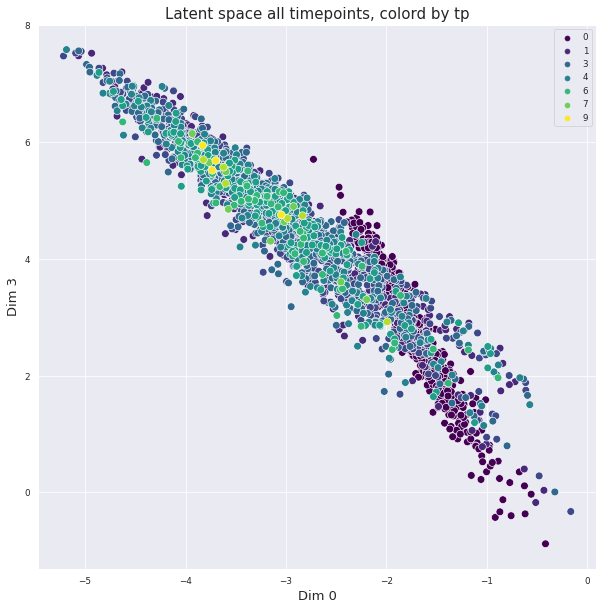

In [22]:
#3 2D Trajectory latent space visualization
dim0=0
dim1=3

#z = z_train + z_test

#plot_z_time_2d(z, max_timepoints, [dim0, dim1], out_dir, out_name='latent_space_2d')
plt.figure(figsize=(10, 10))

# create color cmap
pallete = sns.color_palette("viridis", max_timepoints)

z_d0_full = []
z_d1_full = []
tp_full = []

for tp in range(max_timepoints):

    train_z_d0 = [x[tp, dim0] for x in z_train if x.shape[0] > tp]
    test_z_d0 = [x[tp, dim0] for x in z_test if x.shape[0] > tp]

    train_z_d1 = [x[tp, dim1] for x in z_train if x.shape[0] > tp]
    test_z_d1 = [x[tp, dim1] for x in z_test if x.shape[0] > tp]
    
    z_d0_full = z_d0_full + train_z_d0
    #z_d0_full = z_d0_full + test_z_d0

    z_d1_full = z_d1_full + train_z_d1
    #z_d1_full = z_d1_full +test_z_d1
    
    tp_len = len(train_z_d0)# + len(test_z_d0)
    tp_full = tp_full + [tp]*tp_len


sns.scatterplot(x=z_d0_full,y=z_d1_full,hue=tp_full, palette="viridis", s=60)
##Add title, x and y axis
plt.xlabel(f"Dim {dim0}", size=13)
plt.ylabel(f"Dim {dim1}", size=13)
plt.title(f"Latent space all timepoints, colord by tp", size=15)
plt.show()
